In [ ]:
# drawing density plot for joint counts: https://pysal.org/esda/notebooks/spatialautocorrelation.html
# calculating VIF: https://www.statology.org/how-to-calculate-vif-in-python/

In [ ]:
!pip install mapclassify pysal geodatasets --quiet
!pip install geodatasets pysal contextily seaborn --quiet
!pip install sodapy
!pip install shapely

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [ ]:
#importing packages
from sodapy import Socrata
import geodatasets
import geopandas as gpd
import numpy as np
import mapclassify
import seaborn as sbn
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.model import spreg
from pysal.explore import esda
from pysal.lib import weights
from scipy.stats import pearsonr, boxcox
import pandas as pd
from sklearn.preprocessing import robust_scale
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from shapely.geometry import box, LineString, Point,MultiPoint
import contextily as ctx
from numpy.random import seed
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import plot_moran
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

/usr/local/lib/python3.11/dist-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


<b> Data Preprocessing

In [ ]:
# importing chicago boundary dataset
chicago = gpd.read_file(geodatasets.get_path("geoda.chicago_commpop"))
chicago = chicago.to_crs(3857)

Extracting 'chicago_commpop/chicago_commpop.geojson' from '/root/.cache/geodatasets/chicago_commpop.zip' to '/root/.cache/geodatasets/chicago_commpop.zip.unzip'


In [ ]:
# importing 2020 population dataset

url = "https://en.wikipedia.org/wiki/Community_areas_in_Chicago"

# reading the table directly from the HTML page
tables = pd.read_html(url)
POP2020 = tables[0]

# cleaning the dataset
new_columns = [col[0] for col in POP2020.columns]
POP2020.columns = new_columns
POP2020 = POP2020.head(len(POP2020) - 1)
POP2020['No.'] = POP2020['No.'].astype(int)
POP2020['POP2020'] = POP2020['Population'].astype(int)

# merging the 2020 population data to chicago dataframe
chicago = chicago.merge(POP2020[['POP2020','No.']], left_on='NID', right_on='No.', how='left')
chicago.drop(columns=['No.'], inplace=True)

<ipython-input-5-17710fe0450d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  POP2020['No.'] = POP2020['No.'].astype(int)
<ipython-input-5-17710fe0450d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  POP2020['POP2020'] = POP2020['Population'].astype(int)


In [ ]:
# importing grocery dataset
client = Socrata("data.cityofchicago.org", None)

grocery = client.get("3e26-zek2")

# converting to pandas DataFrame
grocery_df = pd.DataFrame.from_records(grocery)

# creating the longitude column from the location column
grocery_df['Longitude'] = grocery_df['location'].apply(
    lambda x: float(list(x.values())[1][0]) if isinstance(x, dict) and 'coordinates' in x else float('nan')
)

# creating the latitude column from the location column
grocery_df['Latitude'] = grocery_df['location'].apply(
    lambda x: float(list(x.values())[1][1]) if isinstance(x, dict) and 'coordinates' in x else float('nan')
)

# converting data frame to geo-dataframe
grocery_df = gpd.GeoDataFrame(
    grocery_df,
    geometry=gpd.points_from_xy(grocery_df['Longitude'], grocery_df['Latitude']),
    crs="EPSG:4326"
)

grocery_df = grocery_df.to_crs(3857)
grocery_df = grocery_df.drop(columns=['location'])

<Axes: >

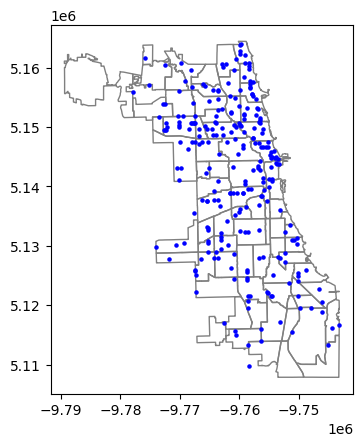

In [ ]:
# plotting groceries in the chicago communities boundary map
base = chicago.plot(facecolor='none', edgecolor='gray')
grocery_df.plot(ax=base, marker='o', color='blue', markersize=5)

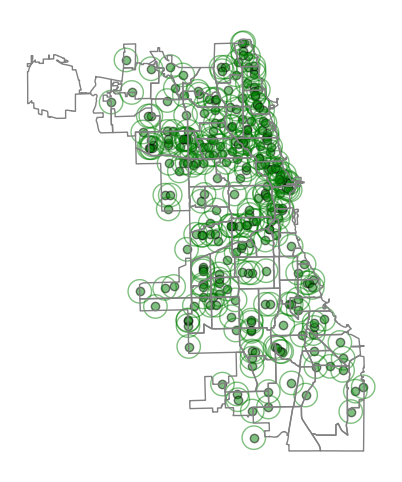

In [ ]:
# creating a 1 mile buffer
grocery_df = grocery_df.to_crs(chicago.crs)
grocery_df_1mile = grocery_df.copy()
grocery_df_1mile.geometry = grocery_df.buffer(1609.34)

# plotting the 1 mile buffer of all groceries over the chicago boundary
ax = grocery_df.plot(facecolor='green', edgecolor='black', figsize=(6,6), alpha=0.5)

grocery_df_1mile.plot(ax=ax, facecolor='none', edgecolor='green', alpha=0.5)

chicago.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=1)

ax.set_axis_off()
plt.show()

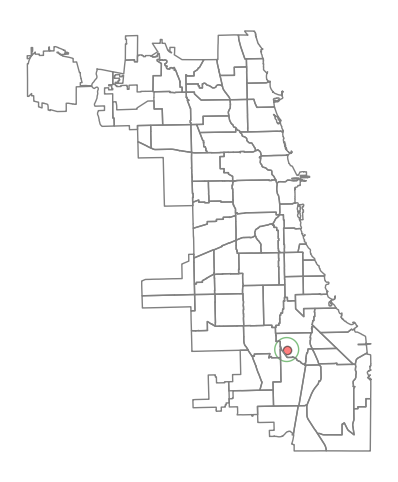

In [ ]:
# plotting the 1 mile buffer of the first grocery over the chicago boundary
ax = grocery_df.iloc[0:1].plot(facecolor='red', edgecolor='black', figsize=(6,6), alpha=0.5)

grocery_df_1mile.iloc[0:1].plot(ax=ax, facecolor='none', edgecolor='green', alpha=0.5)

chicago.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=1)

ax.set_axis_off()
plt.show()

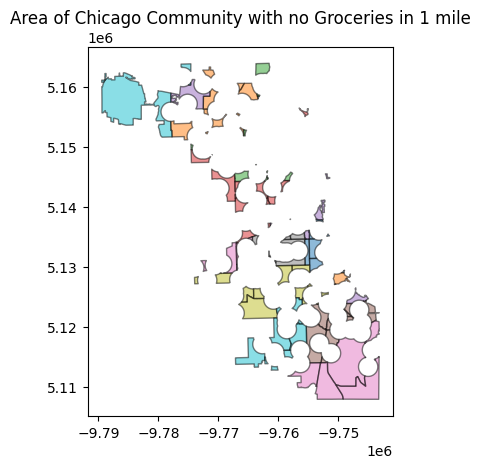

In [ ]:
# showing the area of chicago that does not include 1 mile grocery buffers
chicago_symmetric_difference = chicago.overlay(grocery_df_1mile, how='difference')
chicago_symmetric_difference.plot(alpha=0.5, edgecolor='k', cmap='tab10')

ax.set_axis_off()
plt.title('Area of Chicago Community with no Groceries in 1 mile')

plt.show()

In [ ]:
# performing a spatial join
grocery_chicago = grocery_df_1mile.sjoin(chicago, how="left", predicate="intersects")

# creating a dataframe that displays the number of 1 mile  grocery buffer that intersect with each community
grocery_count = grocery_chicago.groupby('community').size().reset_index(name='grocery_count')

<b> Identifying Food Desert

In [ ]:
# creating a dataframe by adding grocery_count to the chicago dataest
food_access = chicago.merge(grocery_count, on='community', how='left')

# creating a variable that displays number of grocery per 1000 population
food_access['grocery_per_1000'] = food_access['grocery_count'] / (food_access['POP2020'] / 1000)

# setting the threshold for food access by the 1st quantile
summary = food_access['grocery_per_1000'].describe()
threshold = summary['25%']

# creating a variable that evaluates the food access status of each community with the threshold value
food_access['food access'] = food_access['grocery_per_1000'] < threshold

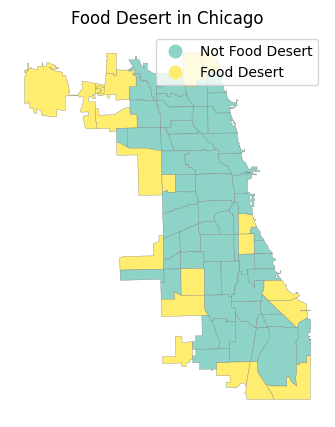

In [ ]:
# plotting the food desert community within chicago based on "food access" variable
fig, ax = plt.subplots(figsize=(5, 5))

food_access.plot(ax=ax, column="food access", categorical=True, legend=True,
             edgecolor="0.5", linewidth=0.25, cmap="Set3")

legend = ax.get_legend()
list(map(lambda label: label.set_text('Food Desert' if label.get_text() == 'True' else 'Not Food Desert') , legend.get_texts()))

ax.set_axis_off()
ax.set_title("Food Desert in Chicago")
plt.show()

<b> Testing the Spatial Autocorrelation within Food Desert using 'food access' Variable

In [ ]:
# creating weights
w = weights.Queen.from_dataframe(food_access)
w.transform = 'R'
w_queen = weights.Queen.from_dataframe(food_access, ids="NID")

# setting seed
seed(0)

# calculating join counts
jc = esda.join_counts.Join_Counts(food_access["food access"], w_queen)

<ipython-input-14-97cf21713f09>:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(food_access)


In [ ]:
# displaying the result of join counts through data frame format
result = {'A pair of neighbouring locations': ['Both are food desert',
                                               'Both are not food desert',
                                               'Only one is food desert',
                                               'Total Joins'],
'Count': map(lambda x: int(x), [jc.bb, jc.ww, jc.bw, jc.J])}
result = pd.DataFrame(result)
print(result)

  A pair of neighbouring locations  Count
0             Both are food desert     10
1         Both are not food desert    133
2          Only one is food desert     54
3                      Total Joins    197


In [ ]:
# displaying the result of join counts through data frame format
table = {'A pair of neighbouring locations': ['Both are food desert',
                                               'Both are not food desert',
                                               'Only one is food desert'],
'Observed Count': map(lambda x: int(x), [jc.bb, jc.ww, jc.bw]),
'Expected Count': map(lambda x: int(x), [jc.mean_bb, jc.ww.mean(), jc.mean_bw]),
'p_value': [jc.p_sim_bb, jc.p_sim_ww, jc.p_sim_bw]
          }
table = pd.DataFrame(table)
print(table)

AttributeError: 'Join_Counts' object has no attribute 'p_sim_ww'

<ipython-input-17-d82aec003ee6>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(jc.sim_bb, shade=True)


Text(10.5, 0.1, 'Pseudo p-value: 0.746')

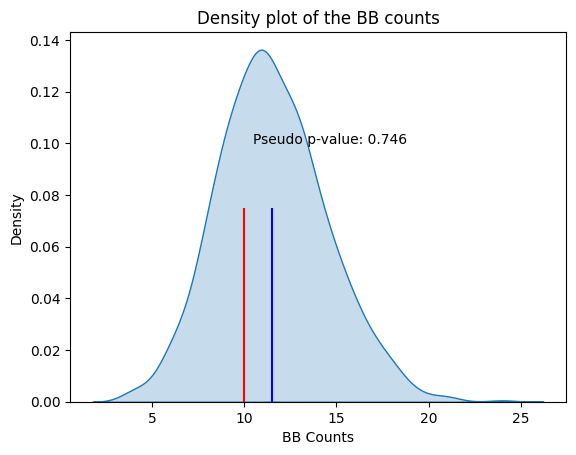

In [ ]:
# displaying density plot of BB counts and correponding p-value
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='red')
plt.vlines(jc.mean_bb, 0,0.075, color = 'blue')
plt.xlabel('BB Counts')
plt.title('Density plot of the BB counts')
plt.text(x=jc.bb + 0.5, y=0.1, s=f"Pseudo p-value: {jc.p_sim_bb}",
         fontsize = 10, color='black')

<b> Relationship between Food Desert and Health-/Socio- Status

In [ ]:
# importing health dataset
health_data = client.get("iqnk-2tcu")
health_df = pd.DataFrame.from_records(health_data)

# merging the health data to food_access dataframe
health_df['community_area'] = health_df['community_area'].astype(int)
merged = food_access.merge(health_df, left_on='NID', right_on='community_area', how='left', suffixes=('_food', '_health'))

In [ ]:
# getting the list of dependents variables for the regression
variables = list(merged.columns)[15:]

# converting variables to numeric type
for var in merged.columns:
    if var in variables:
        merged[var] = pd.to_numeric(merged[var], errors='coerce')

# converting 'food access' variable to integer type
merged['food access'] = merged['food access'].astype(int)

                                            birth_rate  \
birth_rate                                    1.000000   
general_fertility_rate                        0.810334   
low_birth_weight                              0.108179   
prenatal_care_beginning_in_first_trimester   -0.178847   
preterm_births                                0.004334   
teen_birth_rate                               0.612710   
assault_homicide                              0.188536   
breast_cancer_in_females                     -0.022201   
cancer_all_sites                             -0.001289   
colorectal_cancer                            -0.097507   
diabetes_related                              0.303831   
firearm_related                               0.162722   
infant_mortality_rate                         0.051716   
lung_cancer                                  -0.063567   
prostate_cancer_in_males                      0.130114   
stroke_cerebrovascular_disease                0.126423   
childhood_bloo

<Axes: >

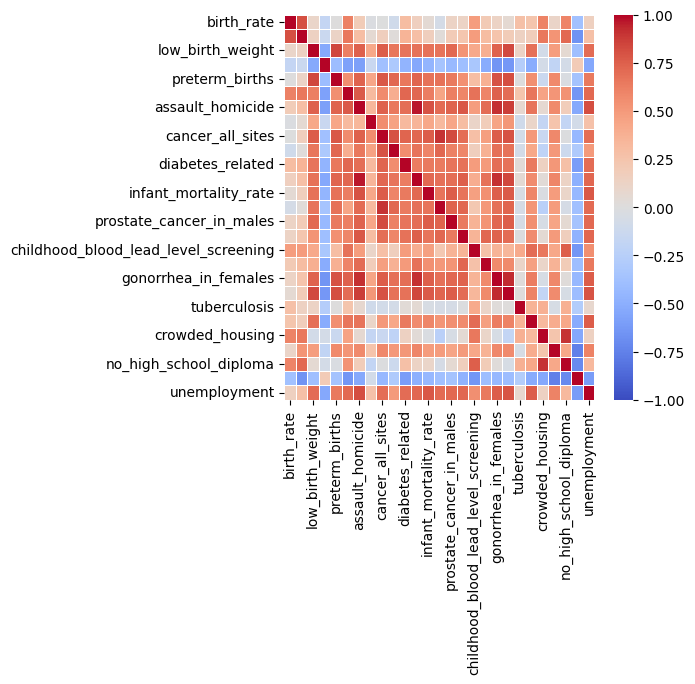

In [ ]:
# retrieving the correlation matrix of dependent variables
correlation_matrix = merged[variables].corr()
print(correlation_matrix)

# visualising the correlation heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)

In [ ]:
# calculating VIF of each dependent variables

X = merged[variables]
X = X.fillna(X.mean())
X = add_constant(X)
indicators_vif_data = pd.DataFrame()
indicators_vif_data['variable'] = X.columns
indicators_vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(indicators_vif_data)

                                      variable          VIF
0                                        const  1413.130327
1                                   birth_rate    12.608648
2                       general_fertility_rate    24.977271
3                             low_birth_weight     9.862881
4   prenatal_care_beginning_in_first_trimester     3.108157
5                               preterm_births     7.454690
6                              teen_birth_rate    12.249356
7                             assault_homicide    53.709304
8                     breast_cancer_in_females     2.950413
9                             cancer_all_sites    30.387553
10                           colorectal_cancer     4.064669
11                            diabetes_related     5.983552
12                             firearm_related    48.116229
13                       infant_mortality_rate     5.964172
14                                 lung_cancer    16.605934
15                    prostate_cancer_in

In [ ]:
# retriving the data that will not be used (threshold VIF <10)
take_lst = list(indicators_vif_data[indicators_vif_data['VIF'] < 10]['variable'])

# getting the list of variables that does not have VIF greater than 10
variables_rf= [var for var in variables if var in take_lst]
for var in variables_rf:
    if var in merged.columns:
        merged[var].fillna(merged[var].mean(), inplace=True)

<ipython-input-22-6f0697be5113>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged[var].fillna(merged[var].mean(), inplace=True)


In [ ]:
for var in variables:
    if var in merged.columns:
        merged[var].fillna(merged[var].mean(), inplace=True)

<ipython-input-23-ea7c25aaae94>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged[var].fillna(merged[var].mean(), inplace=True)


In [ ]:
# performing OLS with the full model

m1_full = spreg.OLS(
    merged[['food access']].values,
    merged[variables].values,
    name_y='food access',
    name_x= variables,
)
print(m1_full.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : food access                Number of Observations:          77
Mean dependent var  :      0.2468                Number of Variables   :          28
S.D. dependent var  :      0.4339                Degrees of Freedom    :          49
R-squared           :      0.4685
Adjusted R-squared  :      0.1757
Sum squared residual:     7.60608                F-statistic           :      1.6000
Sigma-square        :       0.155                Prob(F-statistic)     :     0.07556
S.E. of regression  :       0.394                Log likelihood        :     -20.136
Sigma-square ML     :       0.099                Akaike info criterion :      96.273
S.E of regression ML:      0.3143                Schwarz criterion     :     161.899

------------------------------------------------------------

In [ ]:
# performing OLS with the reduced model

m1 = spreg.OLS(
    merged[['food access']].values,
    merged[variables_rf].values,
    name_y='food access',
    name_x= variables_rf,
)
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : food access                Number of Observations:          77
Mean dependent var  :      0.2468                Number of Variables   :          16
S.D. dependent var  :      0.4339                Degrees of Freedom    :          61
R-squared           :      0.2287
Adjusted R-squared  :      0.0391
Sum squared residual:     11.0384                F-statistic           :      1.2059
Sigma-square        :       0.181                Prob(F-statistic)     :      0.2923
S.E. of regression  :       0.425                Log likelihood        :     -34.475
Sigma-square ML     :       0.143                Akaike info criterion :     100.950
S.E of regression ML:      0.3786                Schwarz criterion     :     138.451

------------------------------------------------------------

In [ ]:
# performing spatial error regression with full model
m2_full = spreg.GM_Error_Het(
    merged[['food access']].values,
    merged[variables].values,
    w=w,
    name_y='food access',
    name_x= variables,
)
print(m2_full.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES (HET)
------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : food access                Number of Observations:          77
Mean dependent var  :      0.2468                Number of Variables   :          28
S.D. dependent var  :      0.4339                Degrees of Freedom    :          49
Pseudo R-squared    :      0.4681
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -1.41103         1.36837        -1.03118         0.30246
          birth_rate        -0.01363         0.03396    

In [ ]:
# performing spatial error regression with reduced model
m2 = spreg.GM_Error_Het(
    merged[['food access']].values,
    merged[variables_rf].values,
    w=w,
    name_y='food access',
    name_x= variables_rf,
)
print(m2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES (HET)
------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : food access                Number of Observations:          77
Mean dependent var  :      0.2468                Number of Variables   :          16
S.D. dependent var  :      0.4339                Degrees of Freedom    :          61
Pseudo R-squared    :      0.2268
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -0.71429         1.53713        -0.46469         0.64215
    low_birth_weight        -0.03078         0.02491    

In [ ]:
# performing spatial lag regression with full model
m3_full = spreg.GM_Lag(
    merged[['food access']].values,
    merged[variables].values,
    w=w,
    name_y='food access',
    name_x= variables,
)
print(m3_full.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : food access                Number of Observations:          77
Mean dependent var  :      0.2468                Number of Variables   :          29
S.D. dependent var  :      0.4339                Degrees of Freedom    :          48
Pseudo R-squared    :      0.4685
Spatial Pseudo R-squared:  0.4562

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -1.73106         1.37532        -1.25866         0.20815
          birth_rate        -0.00820         0.03646        -0.22477         0.82216
general_fertility_rate         0.01055    

In [ ]:
# performing spatial lag regression with reduced model
m3 = spreg.GM_Lag(
    merged[['food access']].values,
    merged[variables_rf].values,
    w=w,
    name_y='food access',
    name_x= variables_rf,
)
print(m3.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : food access                Number of Observations:          77
Mean dependent var  :      0.2468                Number of Variables   :          17
S.D. dependent var  :      0.4339                Degrees of Freedom    :          60
Pseudo R-squared    :      0.2478
Spatial Pseudo R-squared:  0.1384

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -1.25347         1.38108        -0.90761         0.36409
    low_birth_weight        -0.03357         0.02675        -1.25517         0.20942
prenatal_care_beginning_in_first_trimester

In [ ]:
merged['breast_cancer_in_females'].describe()

,breast_cancer_in_females
count,77.000000
mean,25.951948
std,9.557590
min,7.600000
25%,20.200000
50%,24.000000
75%,32.700000
max,54.700000
